# Customer Segmentation using Clustering
***
This mini-project is based on [this blog post]() by yhat. Please feel free to refer to the post for additional information, and solutions.

In [1]:
import pandas as pd
import seaborn as sns

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Data

The dataset contains both information on marketing newsletters/e-mail campaigns (e-mail offers sent) and transaction level data from customers (which offer customers responded to and what they bought).

In [3]:
df_offers = pd.read_excel("./WineKMC.xlsx", sheetname=0)
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


In [4]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheetname=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


## Data wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

**Your turn:** Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):

* customer_name
* One column for each offer, with a 1 if the customer responded to the offer

In [76]:
#your turn
df = df_offers.merge(df_transactions)
responded_offers_per_customter = df.pivot_table(values = 'n', index = 'customer_name', columns = 'offer_id')
responded_offers_per_customter.head()

offer_id,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,32
customer_name,,,,,,,,,,,,,,,,,,,,,
Adams,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN
Allen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
Anderson,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
Bailey,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
Baker,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN


## K-Means Clustering

**Your turn:** 

* Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
* Apply the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. Use `n_clusters=5` (but feel free to play with this)
* Print the number of points in each cluster 

In [126]:
# Create a numpy matrix x_cols with only the columns representing the offers (i.e. the 0/1 colums)
df = responded_offers_per_customter
df.fillna(0, inplace = True)
x_cols = pd.np.matrix(df)
x_cols

matrix([[ 0.,  0.,  0., ...,  1.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 1.,  0.,  0., ...,  0.,  1.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  1.,  1.]])

In [127]:
# Apply the KMeans clustering method from scikit-learn to this matrix.
import sklearn
from sklearn import cluster
kmeans = cluster.KMeans(n_clusters = 5)
kmeans.fit(x_cols)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=5, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

In [90]:
# Print the number of points in each cluster
clusters_per_customer = kmeans.predict(x_cols)

df = pd.DataFrame(clusters_per_customer, columns = ['cluster_id'])
df.reset_index(inplace = True)
df.rename(columns = {'index':'num points'}, inplace = True)
cluster_info = df.groupby('cluster_id').count()
cluster_info

,num points
cluster_id,
0,6
1,21
2,26
3,31
4,16


## Visualizing clusters using PCA

How do we visualize clusters? Principal Component Analysis (PCA) will help. There are lots of uses for PCA, but today we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset. Why you ask? Well once it is in 2 dimensions (or simply put, it has 2 columns), it becomes much easier to plot!

**Your turn:** Use PCA to plot your clusters:

* Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
* Create a data frame with the following fields:
  * customer name
  * cluster id the customer belongs to
  * the two PCA components (label them `x` and `y`)

In [97]:
# Reduce the dimensionality of your clustering data to 2 components
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
pca.fit(x_cols)

# Create a data frame with the following fields:
#  customer name
#  cluster id the customer belongs to
#  the two PCA components (label them x and y)
df = pd.DataFrame(pca.fit_transform(x_cols), columns = ['x', 'y'])
df['customer_name'] = responded_offers_per_customter.index
df['cluster_id'] = clusters_per_customer

# Reorder columns
cols = df.columns.tolist()
cols = cols[-2:] + cols[:-2]
customers_fitted_2D = df[cols]
customers_fitted_2D.head()

,customer_name,cluster_id,x,y
0,Adams,2,-1.007580,0.108215
1,Allen,3,0.287539,0.044715
2,Anderson,4,0.392032,1.038391
3,Bailey,2,-0.699477,-0.022542
4,Baker,3,-0.088183,-0.471695


What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We'll color code each point based on it's cluster so it's easier to see them.

**Your turn:**

* Plot a scatterplot of the `x` vs `y` columns
* Color-code points differently based on cluster ID

How do the clusters look?

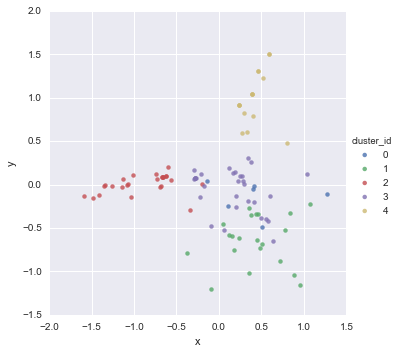

In [115]:
import matplotlib.pyplot as plt

df = customers_fitted_2D

sns.lmplot('x', 'y', data=df, hue='cluster_id', fit_reg=False)
plt.show()

Clusters 2 and 4 (red and yellow) seem to be well classified, with most falling inside a contiguous boundary.

There is alot of overlap in remaining 3 clusters (0, 1, 3). Perhaps the model would be better fit if there was no cluster 0. Or similarly if clusters (0, 1, 3) were a single cluster.

Perhaps either of these scenarios would work better with k = 3, or k = 5.

That being, said its difficult to conclude that this would be the case, since the choice of dimensions 2 in the PCA, might be inappropriate as shown by PCA Explained Variance Ratio.

In 2D, it only explains ~25% of the variance

In [125]:
# PCA using 2D
pca = PCA(n_components = 2)
pca.fit(x_cols)
print('PCA explained variance ratio per feature, dimension == %d:' % len(pca.explained_variance_ratio_)) 
print(pca.explained_variance_ratio_)

# PCA using all features
pca = PCA(n_components = x_cols.shape[1])
pca.fit(x_cols)
print('PCA explained variance ratio per feature, (maximum) dimension == %d:' % len(pca.explained_variance_ratio_)) 
print(pca.explained_variance_ratio_)

PCA explained variance ratio per feature, dimension == 2:
[ 0.14386393  0.10800289]
PCA explained variance ratio per feature, (maximum) dimension == 32:
[ 0.14386393  0.10800289  0.07104281  0.05866151  0.05273181  0.05037351
  0.04853032  0.04281792  0.04086488  0.03794334  0.03490044  0.03334871
  0.03051951  0.02548482  0.02321341  0.02193338  0.01978732  0.01870919
  0.016607    0.0154309   0.01369783  0.01273333  0.01213607  0.01136126
  0.01032716  0.00919489  0.00810601  0.00752468  0.00660726  0.00580346
  0.0050086   0.00273186]


**Your turn (extra credit):** Play with the following: 

* Different initializations for `KMeans`
* Other clustering algorithms in scikit-learn